In [26]:
%matplotlib inline
# Dependencies: Matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns 

In [27]:
# Dependencies: Analytics
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper dep
# Dependencies: SQLalchemy ORM, imported inspect function
# Andrew: Here I'm using SQLalchemy 2.0 instead of 1.4
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [29]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables

In [31]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [32]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Import inspection element
from sqlalchemy import inspect
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
station_columns = inspector.get_columns('station')

# inspect columns
print('measurement columns:')
for col in measurement_columns:
    print(col)
print('-'*100)
print('station columns:')
for col in station_columns:
    print(col)
    

measurement columns:
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}
----------------------------------------------------------------------------------------------------
station columns:
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': No

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [34]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(recent_date)

2017-08-23


In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt
date_12_months_ago = dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=365)
print(date_12_months_ago)

sel = [Measurement.date,
       func.sum(Measurement.prcp)]
fiscal_year_precip = session.query(*sel). \
    filter(func.strftime(Measurement.date) > date_12_months_ago). \
    group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(fiscal_year_precip, columns=['Date', 'Precipitation']). \
    sort_values('Date'). \
    reset_index(drop=True)

# Check na values
print(precipitation_df.info())
precipitation_df.dropna(inplace=True)

# Change d-type for Date, capture only dates
print(precipitation_df.dtypes)
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date']).dt.date

# Sort the dataframe by date
# Sorted when creating df

2016-08-23 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           365 non-null    object 
 1   Precipitation  365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None
Date              object
Precipitation    float64
dtype: object


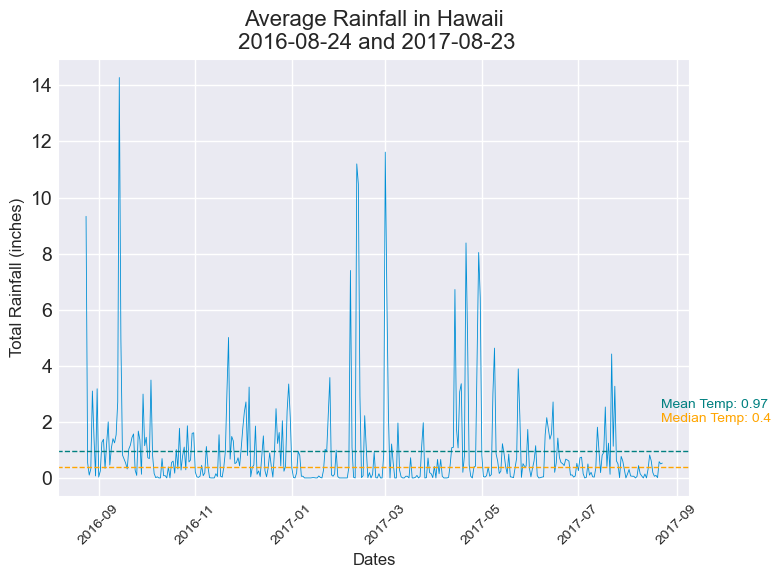

In [47]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=precipitation_df, x=precipitation_df.Date, y=precipitation_df.Precipitation, linewidth=0.6, ax=ax)
ax.set_title(f'Average Rainfall in Hawaii\n {precipitation_df.Date.min()} and {precipitation_df.Date.max()}', fontsize=16)
# Set Labels
ax.set_ylabel('Total Rainfall (inches)', fontsize=12)
ax.set_xlabel('Dates', fontsize=12)
ax.tick_params(axis='x', rotation=45, labelsize=10)
# Annotations
plt.axhline(precipitation_df.Precipitation.mean(), linestyle='--', color='teal', linewidth=1)
plt.axhline(precipitation_df.Precipitation.median(), linestyle='--', color='orange', linewidth=1)
plt.text(17400, 2, s=f'Mean Temp: {round(precipitation_df.Precipitation.mean(), 2)}', fontsize=10, color='teal')
plt.text(17400, 2.5, s=f'Median Temp: {round(precipitation_df.Precipitation.median(), 2)}', fontsize=10, color='orange')
# Export
plt.tight_layout()
plt.savefig('Images/rainfall.png', format='png', dpi=150)
plt.show()
plt.clf()

In [37]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(func.distinct(Measurement.station))).all()[0][0]

9

In [39]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [40]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.date),
       func.max(Measurement.date),
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.round(func.avg(Measurement.tobs), 2)]

top_weather_station_summary= session.query(*sel). \
    filter((Measurement.station == most_active_stations[0][0])). \
    group_by(Measurement.station).all()

top_weather_station_summary

[('USC00519281', '2010-01-01', '2017-08-18', 54.0, 85.0, 71.66)]

In [41]:
# Query most active station
sel = [Measurement.station,
       Measurement.date,
       Measurement.tobs]

top_weather_station = session.query(*sel). \
    filter(func.strftime((Measurement.date) > date_12_months_ago), (Measurement.station == most_active_stations[0][0])).all()

top_weather_station_df = pd.DataFrame(top_weather_station, columns=['Name', 'Date', 'Temp_f'])
top_weather_station_df.reset_index(inplace=True)
top_weather_station_df

,index,Name,Date,Temp_f
0,0,USC00519281,2016-08-24,77.0
1,1,USC00519281,2016-08-25,80.0
2,2,USC00519281,2016-08-26,80.0
3,3,USC00519281,2016-08-27,75.0
4,4,USC00519281,2016-08-28,73.0
...,...,...,...,...
346,346,USC00519281,2017-08-14,77.0
347,347,USC00519281,2017-08-15,77.0
348,348,USC00519281,2017-08-16,76.0
349,349,USC00519281,2017-08-17,76.0


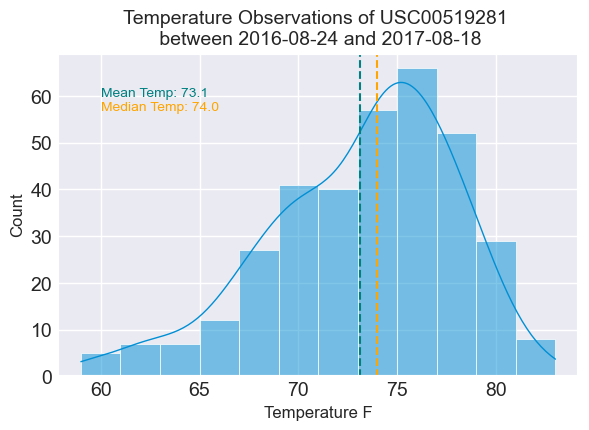

<Figure size 640x480 with 0 Axes>

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data= top_weather_station_df, x='Temp_f', bins=12, kde=True, line_kws=({'linewidth': 1}))
ax.set_title(f'Temperature Observations of {top_weather_station_df.Name.unique()[0]} \n between {top_weather_station_df.Date.min()} and {top_weather_station_df.Date.max()}', fontsize=14)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Temperature F', fontsize=12)
plt.axvline(top_weather_station_df.Temp_f.mean(), linestyle='--', color='teal', linewidth=1.5)
plt.axvline(top_weather_station_df.Temp_f.median(), linestyle='--', color='orange', linewidth=1.5)
plt.text(60, 60, s=f'Mean Temp: {round(top_weather_station_df.Temp_f.mean(), 2)}', fontsize=10, color='teal')
plt.text(60, 57, s=f'Median Temp: {round(top_weather_station_df.Temp_f.median(), 2)}', fontsize=10, color='orange')
plt.show()
plt.savefig('Images/USC00519281.png', format='png', dpi=150)
plt.clf()


# Close Session

In [43]:
# Close Session
session.close()